In [10]:
#Bungein J Cheng
#Cell 1
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#check for GPU availability
print(f"Using device: {device}")

df = pd.read_csv('gan_dataset.csv')#read and prepare data
print("\nDataset shape:", df.shape)

scaler = StandardScaler()#standardize features
scaled_features = scaler.fit_transform(df.values)

data_tensor = torch.FloatTensor(scaled_features).to(device)#convert to PyTorch tensor

dataset = TensorDataset(data_tensor)#create dataset and dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Using device: cpu

Dataset shape: (2000, 5)


In [11]:
#Cell 2
class Generator(nn.Module):#define Generator
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        
        # neural network with larger layers for better feature generation
        self.model = nn.Sequential(
            
            nn.Linear(latent_dim, 256),#first layer expands the latent space
            nn.ReLU(),
            
            nn.Linear(256, 512),#hidden layers with increasing complexity
            nn.ReLU(),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
           
            nn.Linear(256, output_dim), #output layer for 5 features
            # no activation in the last layer to allow for both positive and negative values
        )
        
    def forward(self, z):
        return self.model(z)

#define discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(#first layer processes the 5-dimensional input
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),#hidden layers
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1),#output layer with sigmoid for probability
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
#Cell 3
#initialize models
latent_dim = 100  #size of the noise vector
output_dim = 5 #number of features to generate
generator = Generator(latent_dim, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

criterion = nn.BCELoss()# loss function

# optimizers with learning rate 0.001
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

print("Generator architecture:")
print(generator)
print("\nDiscriminator architecture:")
print(discriminator)

Generator architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=256, out_features=5, bias=True)
  )
)

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(


Target losses achieved at epoch 3!
Discriminator loss: 1.3854
Generator loss: 0.6987


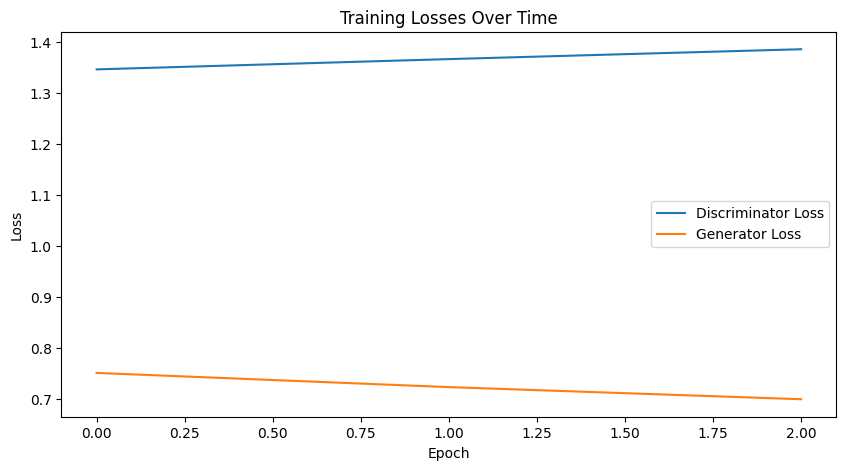

In [13]:
#Cell 4
#training parameters
num_epochs = 300 #increased epochs for better convergence
batch_size = 64 # adjusted batch size
train_losses_d = []
train_losses_g = []

for epoch in range(num_epochs):#training loop
    d_losses = []
    g_losses = []
    
    for batch_idx, real_data in enumerate(dataloader):
        batch_size = real_data[0].size(0)
        
        real_label = torch.ones(batch_size, 1).to(device)#create labels for real and fake data
        fake_label = torch.zeros(batch_size, 1).to(device)
        
        d_optimizer.zero_grad()#train Discriminator 
        
        real_output = discriminator(real_data[0])#train on real data
        d_loss_real = criterion(real_output, real_label)
        
        z = torch.randn(batch_size, latent_dim).to(device)#train on fake data
        fake_data = generator(z)
        fake_output = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_output, fake_label)
        
        d_loss = d_loss_real + d_loss_fake #combined discriminator loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()#train Generator 
        
        z = torch.randn(batch_size, latent_dim).to(device)#generate new fake data and compute loss
        fake_data = generator(z)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, real_label)
        
        g_loss.backward()
        g_optimizer.step()
        
        d_losses.append(d_loss.item())#store losses
        g_losses.append(g_loss.item())
    
    avg_d_loss = sum(d_losses) / len(d_losses)#calculate average losses for the epoch
    avg_g_loss = sum(g_losses) / len(g_losses)
    train_losses_d.append(avg_d_loss)
    train_losses_g.append(avg_g_loss)
    
    if (epoch + 1) % 10 == 0:#print progress every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {avg_d_loss:.4f}, g_loss: {avg_g_loss:.4f}')
    
    if avg_d_loss < 1.4 and avg_g_loss < 0.7:#check if target losses are achieved
        print(f'\nTarget losses achieved at epoch {epoch+1}!')
        print(f'Discriminator loss: {avg_d_loss:.4f}')
        print(f'Generator loss: {avg_g_loss:.4f}')
        break
plt.figure(figsize=(10,5))#plot training losses
plt.plot(train_losses_d, label='Discriminator Loss')
plt.plot(train_losses_g, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses Over Time')
plt.show()


First 20 rows of generated data:
    Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0    0.859459   0.630500   0.512573   1.687318   2.602159
1    0.724201   0.484277   0.353044   1.396522   2.102178
2    0.443299   0.197036   0.097547   0.853176   1.306212
3    0.737850   0.499486   0.393876   1.392755   2.173187
4    0.160877   0.041160  -0.004144   0.337620   0.519625
5    0.043089  -0.011830  -0.013158   0.119895   0.197374
6    0.125838   0.031526   0.018034   0.307507   0.470539
7    0.817315   0.624301   0.530258   1.660406   2.532586
8    0.711273   0.523961   0.392685   1.454595   2.168073
9    0.461100   0.211448   0.097730   0.904420   1.418609
10   0.262963   0.120881   0.039662   0.544942   0.796702
11   0.384147   0.156164   0.052168   0.779116   1.191483
12   0.288501   0.113033   0.041426   0.541557   0.883937
13   0.392748   0.169703   0.059396   0.830324   1.203293
14   0.600345   0.345589   0.229489   1.197654   1.831685
15   0.103325   0.015356  -0.010811   

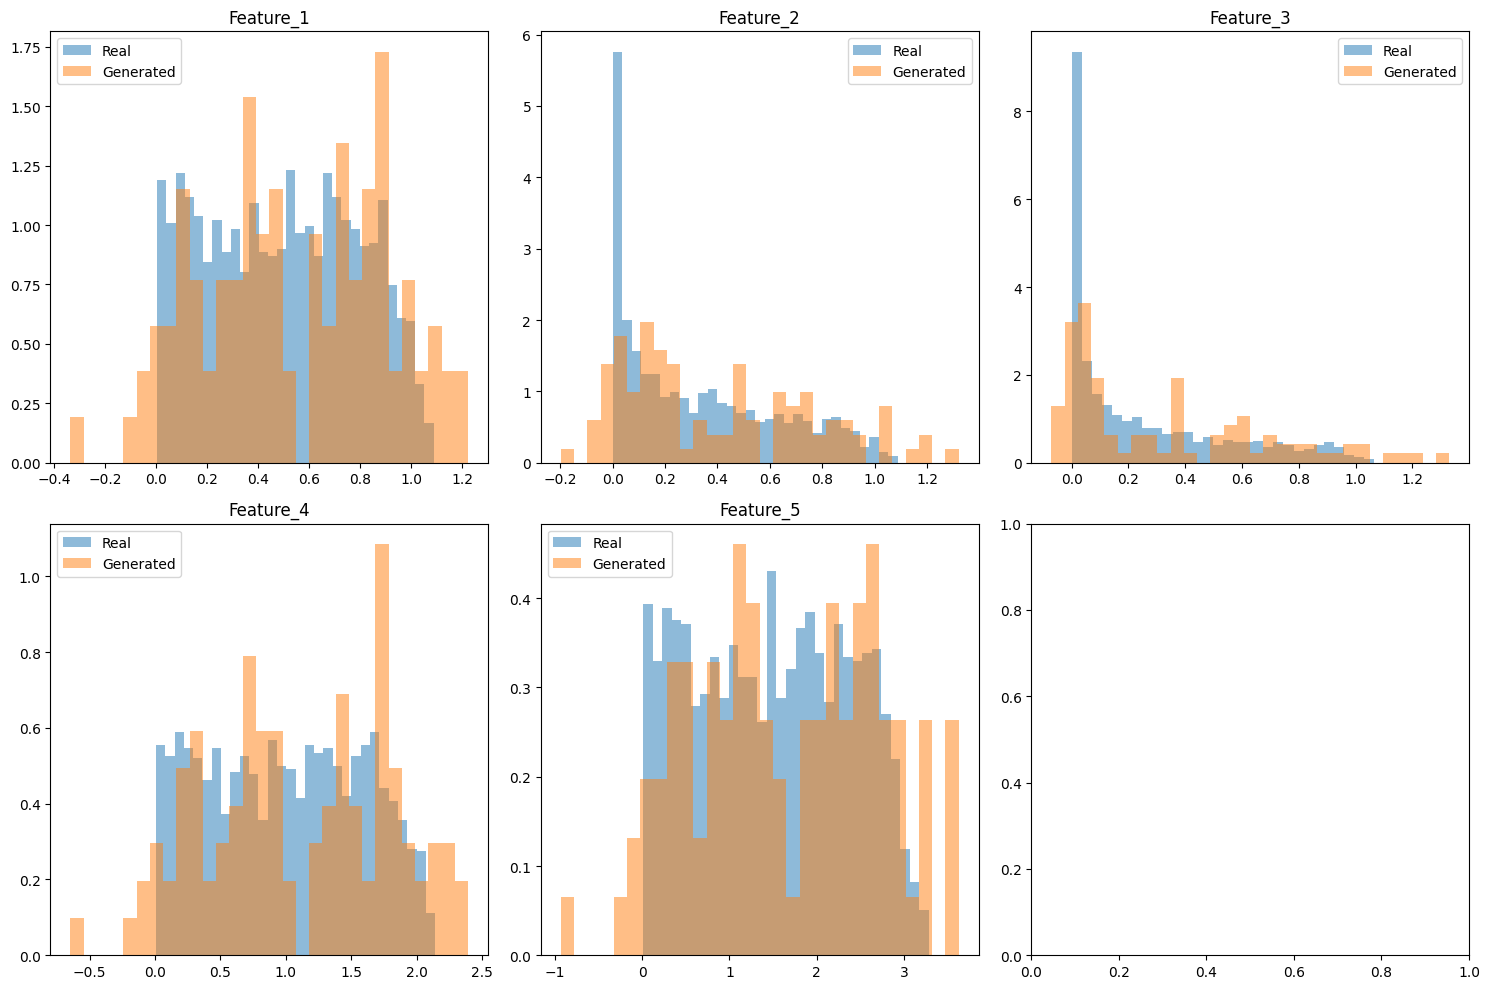

In [14]:
#Cell 5
#generate synthetic data
generator.eval()#set generator to evaluation mode
with torch.no_grad():
    z = torch.randn(100, latent_dim).to(device)#generate 100 samples
    synthetic_data = generator(z).cpu().numpy()
    
    #inverse transform the data to original scale
    synthetic_data_original = scaler.inverse_transform(synthetic_data)
    
    #create DataFrame with generated samples
    generated_df = pd.DataFrame(synthetic_data_original, columns=df.columns)
    
    print("\nFirst 20 rows of generated data:")#print first 20 rows
    print(generated_df.head(20))
    
    generated_df.to_csv('synthetic_data.csv', index=False)#save generated data to CSV
    
print("\nGenerated Data Statistics:")#calculate and print statistics
print(generated_df.describe())

print("\nOriginal Data Statistics:")#compare with original data statistics
print(df.describe())

fig, axes = plt.subplots(2, 3, figsize=(15, 10))#visualize distribution of generated vs real data
axes = axes.ravel()

for idx, column in enumerate(df.columns):#loop through columns
    if idx < len(axes):
        axes[idx].hist(df[column], bins=30, alpha=0.5, label='Real', density=True)#plot histogram of real data
        #plot histogram of generated data
        axes[idx].hist(generated_df[column], bins=30, alpha=0.5, label='Generated', density=True)
        axes[idx].set_title(column)
        axes[idx].legend()

plt.tight_layout()
plt.show()

In [15]:
#Cell 6
#loss function
criterion = nn.BCELoss()

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#Cell 7
num_epochs = 200
d_losses = []
g_losses = []

for epoch in range(num_epochs):#training loop
    for batch_idx, real_data in enumerate(dataloader):
        batch_size = real_data[0].size(0)
        
        real_labels = torch.ones(batch_size, 1).to(device)#create labels
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        d_optimizer.zero_grad()#train discriminator
        
        d_output_real = discriminator(real_data[0])#real data
        d_loss_real = criterion(d_output_real, real_labels)
        
        z = torch.randn(batch_size, latent_dim).to(device) #fake data
        fake_data = generator(z)
        d_output_fake = discriminator(fake_data.detach())
        d_loss_fake = criterion(d_output_fake, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake#combined loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()# train Generator
        
        # generate fake data again 
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z)
        d_output_fake = discriminator(fake_data)
        
        g_loss = criterion(d_output_fake, real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    # save losses for plotting
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

Epoch [10/200], d_loss: 1.3858, g_loss: 0.6620
Epoch [20/200], d_loss: 1.3921, g_loss: 0.6887
Epoch [30/200], d_loss: 1.3832, g_loss: 0.6965
Epoch [40/200], d_loss: 1.3794, g_loss: 0.6930
Epoch [50/200], d_loss: 1.3878, g_loss: 0.6991
Epoch [60/200], d_loss: 1.3900, g_loss: 0.6958
Epoch [70/200], d_loss: 1.3857, g_loss: 0.6841
Epoch [80/200], d_loss: 1.3802, g_loss: 0.7043
Epoch [90/200], d_loss: 1.3802, g_loss: 0.7207
Epoch [100/200], d_loss: 1.4034, g_loss: 0.6695
Epoch [110/200], d_loss: 1.3969, g_loss: 0.6976
Epoch [120/200], d_loss: 1.3849, g_loss: 0.7189


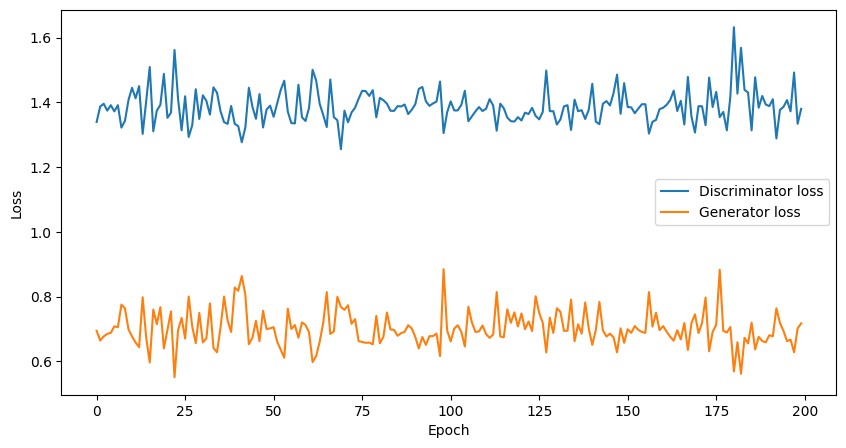

In [8]:
#Cell 8
# Plot losses
plt.figure(figsize=(10,5))
plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
#Cell 9
generator.eval()# generate new samples
with torch.no_grad(): # disable gradient calculation
    z = torch.randn(100, latent_dim).to(device)  #generate 100 new samples
    generated_data = generator(z).cpu().numpy()
    
generated_data_original = scaler.inverse_transform(generated_data)#inverse transform the generated data to original scale

generated_df = pd.DataFrame(generated_data_original, columns=df.columns)#create DataFrame with generated samples

print("\nGenerated samples:")
print(generated_df.head())

generated_df.to_csv('generated_samples.csv', index=False)#save generated samples to CSV


Generated samples:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0   0.542959   0.303894   0.175416   1.073189   1.595434
1   0.546032   0.346560   0.172913   1.090844   1.680716
2   0.557111   0.359625   0.172095   1.069948   1.701577
3   0.555634   0.360284   0.173783   1.084402   1.680507
4   0.556456   0.347800   0.169592   1.123415   1.662753
